In [3]:
import numpy as np
import pandas as pd

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
import joblib
from joblib import Parallel, delayed, parallel_backend
import multiprocessing
from multiprocessing import Value
from tqdm.auto import tqdm


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap



In [4]:
def name_columns(df):
    column_names = ['ecg_cleaned_mean_p1', 'rr_signal_mean_p1', 'bvp_cleaned_mean_p1', 'gsr_cleaned_mean_p1', 'gsr_tonic_mean_p1', 'gsr_phasic_mean_p1', 'gsr_SMNA_mean_p1', 'rsp_cleaned_mean_p1', 'resp_rate_mean_p1', 'emg_zygo_cleaned_mean_p1', 'emg_coru_cleaned_mean_p1', 'emg_trap_cleaned_mean_p1', 'skt_filtered_mean_p1',
    'ecg_cleaned_min_p1', 'rr_signal_min_p1', 'bvp_cleaned_min_p1', 'gsr_cleaned_min_p1', 'gsr_tonic_min_p1', 'gsr_phasic_min_p1', 'gsr_SMNA_min_p1', 'rsp_cleaned_min_p1', 'resp_rate_min_p1', 'emg_zygo_cleaned_min_p1', 'emg_coru_cleaned_min_p1', 'emg_trap_cleaned_min_p1', 'skt_filtered_min_p1',

    'ecg_cleaned_mean_p2', 'rr_signal_mean_p2', 'bvp_cleaned_mean_p2', 'gsr_cleaned_mean_p2', 'gsr_tonic_mean_p2', 'gsr_phasic_mean_p2', 'gsr_SMNA_mean_p2', 'rsp_cleaned_mean_p2', 'resp_rate_mean_p2', 'emg_zygo_cleaned_mean_p2', 'emg_coru_cleaned_mean_p2', 'emg_trap_cleaned_mean_p2', 'skt_filtered_mean_p2',
    'ecg_cleaned_min_p2', 'rr_signal_min_p2', 'bvp_cleaned_min_p2', 'gsr_cleaned_min_p2', 'gsr_tonic_min_p2', 'gsr_phasic_min_p2', 'gsr_SMNA_min_p2', 'rsp_cleaned_min_p2', 'resp_rate_min_p2', 'emg_zygo_cleaned_min_p2', 'emg_coru_cleaned_min_p2', 'emg_trap_cleaned_min_p2', 'skt_filtered_min_p2',

    'ecg_cleaned_mean_p3', 'rr_signal_mean_p3', 'bvp_cleaned_mean_p3', 'gsr_cleaned_mean_p3', 'gsr_tonic_mean_p3', 'gsr_phasic_mean_p3', 'gsr_SMNA_mean_p3', 'rsp_cleaned_mean_p3', 'resp_rate_mean_p3', 'emg_zygo_cleaned_mean_p3', 'emg_coru_cleaned_mean_p3', 'emg_trap_cleaned_mean_p3', 'skt_filtered_mean_p3',
    'ecg_cleaned_min_p3', 'rr_signal_min_p3', 'bvp_cleaned_min_p3', 'gsr_cleaned_min_p3', 'gsr_tonic_min_p3', 'gsr_phasic_min_p3', 'gsr_SMNA_min_p3', 'rsp_cleaned_min_p3', 'resp_rate_min_p3', 'emg_zygo_cleaned_min_p3', 'emg_coru_cleaned_min_p3', 'emg_trap_cleaned_min_p3', 'skt_filtered_min_p3']

    # Split the column names into the desired levels
    split_columns = [col.split('_') for col in column_names]

    # Organize the levels and construct a MultiIndex
    levels = [
        [col[0] for col in split_columns],
        ['_'.join(col[1:-2]) for col in split_columns],
        [col[-2] for col in split_columns],
        [col[-1] for col in split_columns],

    ]

    multiindex = pd.MultiIndex.from_arrays(levels, names=['signal', 'preprocess', 'aggregation', 'partition'])
    
    df.columns = multiindex
    return df


# df_importances = pd.DataFrame(all_importances, )
# df_shap_values = pd.DataFrame(all_shap_values)

df_importances = pd.read_csv('feature_importances.csv', index_col=0)

df_importances = name_columns(df_importances)

# df_shap_values = name_columns(df_shap_values)

# df_importances.to_csv('feature_importances.csv')
# df_shap_values.to_csv('shap_values.csv')


display(df_importances)
# display(df_shap_values)



signal            ecg        rr       bvp       gsr                      \
preprocess    cleaned    signal   cleaned   cleaned     tonic    phasic   
aggregation      mean      mean      mean      mean      mean      mean   
partition          p1        p1        p1        p1        p1        p1   
0            0.000013  0.003411  0.000059  0.006454  0.008097  0.115432   
1            0.000050  0.025048  0.000003  0.012625  0.010870  0.006916   
2            0.000099  0.016896  0.000001  0.121520  0.098251  0.004174   
3            0.000304  0.000821  0.000010  0.009490  0.016530  0.000585   
4            0.000030  0.003176  0.000010  0.073633  0.087463  0.009644   
5            0.000015  0.002865  0.000264  0.005374  0.013857  0.008347   
6            0.000029  0.001875  0.000010  0.012294  0.019880  0.003866   
7            0.000037  0.005972  0.000007  0.010176  0.007996  0.001572   

signal                      rsp      resp           emg  ...       gsr  \
preprocess       SMNA   cleaned      rate  zygo_cleaned  ...   cleaned   
aggregation      mean      mean      mean          mean  ...       min   
partition          p1        p1        p1            p1  ...        p3   
0            0.010218  0.001190  0.011178  3.229321e-06  ...  0.016577   
1            0.001855  0.000612  0.007821  3.633319e-05  ...  0.049935   
2            0.008449  0.000380  0.002748  3.747941e-06  ...  0.010337   
3            0.002246  0.000165  0.002482  4.950056e-07  ...  0.001379   
4            0.025101  0.000180  0.005569  1.317970e-05  ...  0.012026   
5            0.002723  0.000617  0.006109  4.624383e-03  ...  0.009796   
6            0.007544  0.000110  0.003194  1.264827e-03  ...  0.019832   
7            0.001257  0.002046  0.005818  8.972759e-07  ...  0.026152   

signal                                          rsp      resp          emg  \
preprocess      tonic    phasic      SMNA   cleaned      rate zygo_cleaned   
aggregation       min       min       min       min       min          min   
partition          p3        p3        p3        p3        p3           p3   
0            0.017369  0.031580  0.002757  0.004516  0.003461     0.016167   
1            0.009525  0.002804  0.006160  0.007215  0.015919     0.005013   
2            0.014308  0.001307  0.000307  0.002472  0.001576     0.000000   
3            0.002793  0.002305  0.001063  0.007961  0.037796     0.000000   
4            0.014489  0.000453  0.000258  0.011492  0.002555     0.013145   
5            0.017876  0.002145  0.004675  0.004830  0.012986     0.029319   
6            0.005249  0.006231  0.000878  0.017725  0.001365     0.000693   
7            0.019828  0.002176  0.000404  0.003356  0.020076     0.006426   

signal                                       skt  
preprocess   coru_cleaned trap_cleaned  filtered  
aggregation           min          min       min  
partition              p3           p3        p3  
0            2.063459e-03     0.005681  0.014028  
1            0.000000e+00     0.000000  0.013016  
2            0.000000e+00     0.000619  0.019358  
3            0.000000e+00     0.000617  0.003362  
4            2.532061e-07     0.008572  0.013097  
5            8.481129e-05     0.003821  0.011867  
6            0.000000e+00     0.026240  0.006533  
7            0.000000e+00     0.001287  0.020633  

[8 rows x 78 columns]

Passing `palette` without assigning `hue` is deprecated.
Passing `palette` without assigning `hue` is deprecated.
Passing `palette` without assigning `hue` is deprecated.


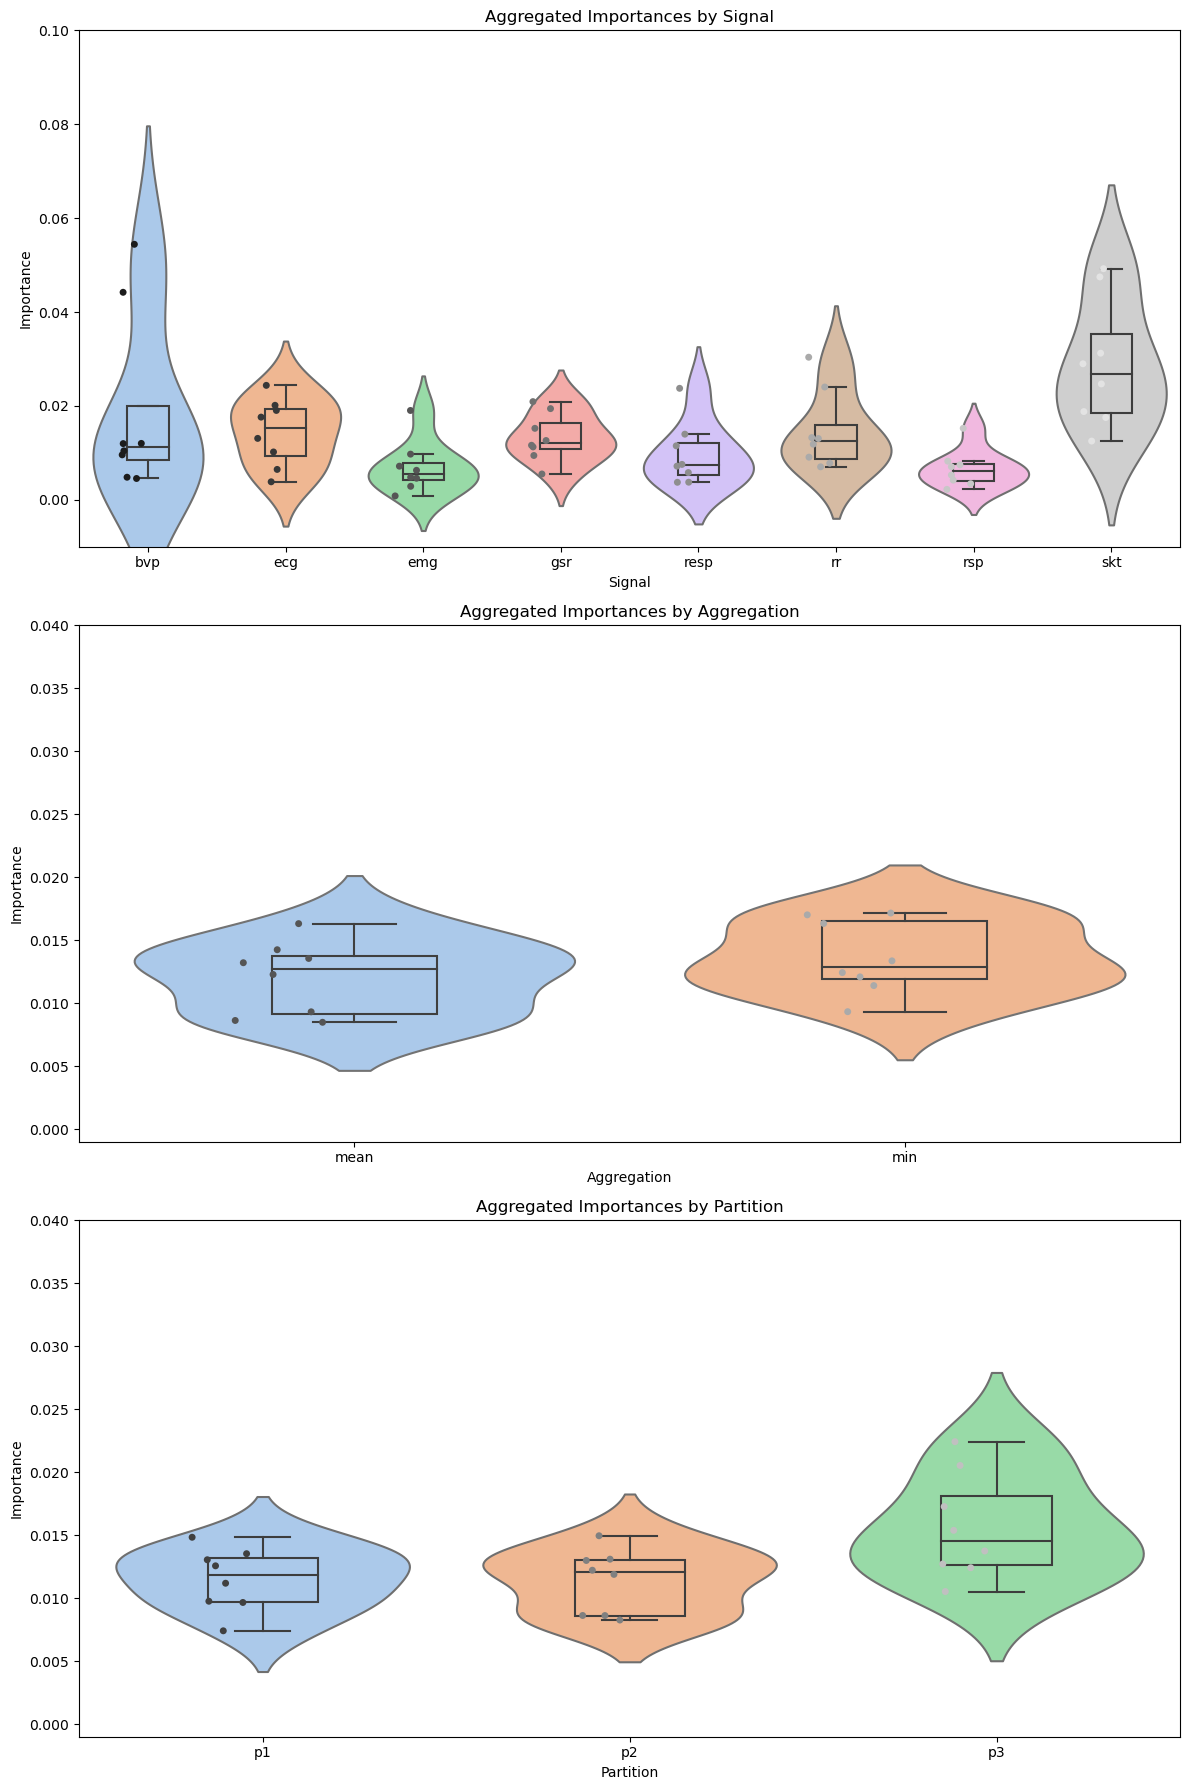

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Group and aggregate the importances by the desired levels
grouped_by_signal = df_importances.groupby(level='signal', axis=1).mean()
grouped_by_aggregation = df_importances.groupby(level='aggregation', axis=1).mean()
grouped_by_partition = df_importances.groupby(level='partition', axis=1).mean()

# Melt the DataFrames for seaborn
grouped_by_signal_melt = grouped_by_signal.melt(var_name="Signal", value_name="Importance")
grouped_by_aggregation_melt = grouped_by_aggregation.melt(var_name="Aggregation", value_name="Importance")
grouped_by_partition_melt = grouped_by_partition.melt(var_name="Partition", value_name="Importance")


fig, axes = plt.subplots(3, 1, figsize=(12, 18))
palette = sns.color_palette("pastel")

box_alpha = 0.7

def plot_half_violin_box_strip(data, x, y, ax):
    sns.violinplot(y=y, x=x, data=data, palette=palette, scale="width", inner=None, ax=ax)
    ylim = ax.get_ylim()

    sns.boxplot(y=y, x=x, data=data, saturation=1, showfliers=False, width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
    old_len_collections = len(ax.collections)
    sns.stripplot(y=y, x=x, data=data, palette = 'gray', ax=ax)
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([-0.12, 0]))
    ax.set_ylim(ylim)
    
plot_half_violin_box_strip(grouped_by_signal_melt, "Signal", "Importance", axes[0])
# axes[0].set_title("Aggregated Importances by Signal")

plot_half_violin_box_strip(grouped_by_aggregation_melt, "Aggregation", "Importance", axes[1])
# axes[1].set_title("Aggregated Importances by Aggregation")

plot_half_violin_box_strip(grouped_by_partition_melt, "Partition", "Importance", axes[2])
# axes[2].set_title("Aggregated Importances by Partition")


# Set y-axis limits to crop extreme points
y_min, y_max = -0.01, 0.2  # Adjust these values based on the desired range
axes[0].set_ylim(-0.01, 0.1 )
axes[1].set_ylim(-0.001, 0.04 )
axes[2].set_ylim(-0.001, 0.04 )

plt.tight_layout()
plt.show()


In [21]:
add_asterisks_anova(axes[0], grouped_by_signal_melt, signal_labels, "Signal", "Importance", 0.095)

nan nan


at least one input has length 0


Data:   Signal  Importance
0    bvp    0.010424
1    bvp    0.004804
2    bvp    0.004535
3    bvp    0.011967
4    bvp    0.009575
ANOVA Table:    Source        SS  DF        MS         F     p-unc       np2
0  Signal  0.002947   7  0.000421  4.273546  0.000763  0.348192
1  Within  0.005516  56  0.000099       NaN       NaN       NaN
Data:   Partition  Importance
0        p1    0.013532
1        p1    0.009758
2        p1    0.014837
3        p1    0.013050
4        p1    0.011186
ANOVA Table:       Source        SS  DF        MS         F     p-unc       np2
0  Partition  0.000095   2  0.000047  4.787601  0.019361  0.313169
1     Within  0.000208  21  0.000010       NaN       NaN       NaN


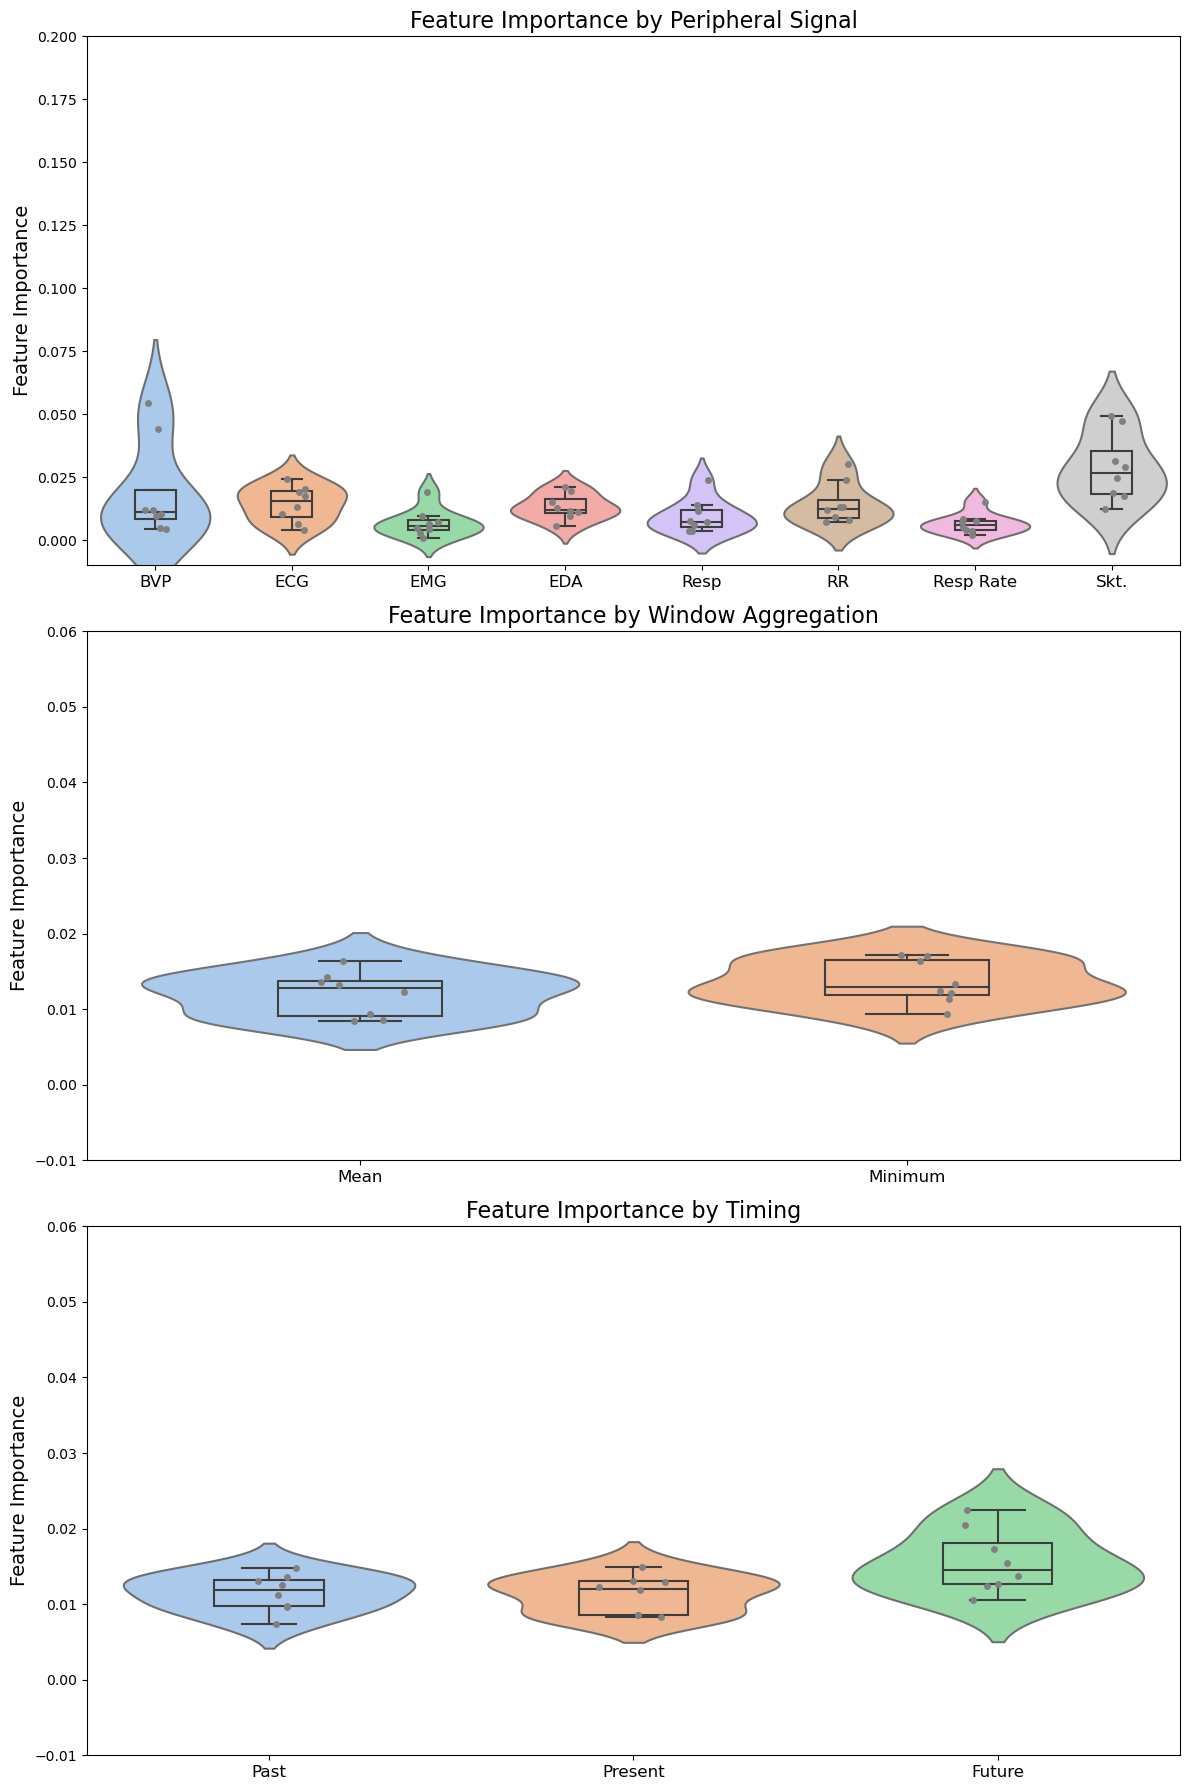

In [22]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind

# Group and aggregate the importances by the desired levels
grouped_by_signal = df_importances.groupby(level='signal', axis=1).mean()
grouped_by_aggregation = df_importances.groupby(level='aggregation', axis=1).mean()
grouped_by_partition = df_importances.groupby(level='partition', axis=1).mean()

# Melt the DataFrames for seaborn
grouped_by_signal_melt = grouped_by_signal.melt(var_name="Signal", value_name="Importance")
grouped_by_aggregation_melt = grouped_by_aggregation.melt(var_name="Aggregation", value_name="Importance")
grouped_by_partition_melt = grouped_by_partition.melt(var_name="Partition", value_name="Importance")

import pingouin as pg

def add_asterisks_anova(ax, data, labels, x_col, y_col, y_offset, alpha=0.05):
    data = data.dropna(subset=[y_col])
    print(f"Data: {data.head()}")
    anova_table = pg.anova(data=data, dv=y_col, between=x_col, detailed=True)
    print(f"ANOVA Table: {anova_table}")
    # p_value = anova_table.loc['Signal', "p-unc"]
    
    # if p_value < alpha:
    #     ax.text(len(labels) / 2, y_offset, "*", ha='center', va='bottom')

    # return p_value  # Add this line to return the p-value


def add_asterisks_ttest(ax, data, labels, x_col, y_col, y_offset, alpha=0.05):
    data = data.dropna(subset=[y_col])
    p_values = []

    for i in range(len(labels) - 1):
        group1 = data[data[x_col] == labels[i]][y_col].dropna()
        group2 = data[data[x_col] == labels[i + 1]][y_col].dropna()
        ttest_result = pg.ttest(group1, group2)
        p_value = ttest_result.at['T-test', 'p-val']
    #     p_values.append(p_value)

    #     if p_value < alpha:
    #         ax.text(i + 0.5, y_offset, "*", ha='center', va='bottom')

    # return p_values




fig, axes = plt.subplots(3, 1, figsize=(12, 18))
palette = sns.color_palette("pastel")

box_alpha = 0.7

# Set labels
signal_labels = ["BVP", "ECG", "EMG", "EDA", "Resp", "RR", "Resp Rate", "Skt."]
aggregation_labels = ["Mean", "Minimum"]
partition_labels = ["Past", "Present", "Future"]

def plot_half_violin_box_strip(data, x, y, ax):
    sns.violinplot(y=y, x=x, data=data, palette=palette, scale="width", inner=None, ax=ax)
    ylim = ax.get_ylim()

    sns.boxplot(y=y, x=x, data=data, saturation=1, showfliers=False, width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
    old_len_collections = len(ax.collections)
    sns.stripplot(y=y, x=x, data=data, color = 'gray', ax=ax)
    # for dots in ax.collections[old_len_collections:]:
    #     dots.set_offsets(dots.get_offsets() + np.array([-0.12, 0]))
    ax.set_ylim(ylim)

plot_half_violin_box_strip(grouped_by_signal_melt, "Signal", "Importance", axes[0])
axes[0].set_title("Feature Importance by Peripheral Signal", fontsize=16)
axes[0].set_xticklabels(signal_labels, fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel("Feature Importance", fontsize=14)
add_asterisks_anova(axes[0], grouped_by_signal_melt, signal_labels, "Signal", "Importance", 0.095)



plot_half_violin_box_strip(grouped_by_aggregation_melt, "Aggregation", "Importance", axes[1])
axes[1].set_title("Feature Importance by Window Aggregation", fontsize=16)
axes[1].set_xticklabels(aggregation_labels, fontsize=12)
axes[1].set_xlabel("")
axes[1].set_ylabel("Feature Importance", fontsize=14)
# add_asterisks_ttest(axes[1], grouped_by_aggregation_melt, aggregation_labels, "Aggregation", "Importance", 0.038)


plot_half_violin_box_strip(grouped_by_partition_melt, "Partition", "Importance", axes[2])
axes[2].set_title("Feature Importance by Timing", fontsize=16)
axes[2].set_xticklabels(partition_labels, fontsize=12)
axes[2].set_xlabel("")
axes[2].set_ylabel("Feature Importance", fontsize=14)
add_asterisks_anova(axes[2], grouped_by_partition_melt, partition_labels, "Partition", "Importance", 0.038)

# Set y-axis limits to crop extreme points
y_min, y_max = -0.01, 0.2  # Adjust these values based on the desired range
axes[0].set_ylim(-0.01, 0.2)
axes[1].set_ylim(-0.01, 0.06)
axes[2].set_ylim(-0.01, 0.06)

plt.tight_layout()
plt.show()

